# Metaheuristic Algorithms
Following sections try some techniques from stochasitic optimization, also known as *metaheuristics*.

In [1]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from alg import *
from utils import *

<AxesSubplot:xlabel='#resources', ylabel='min. makespan'>

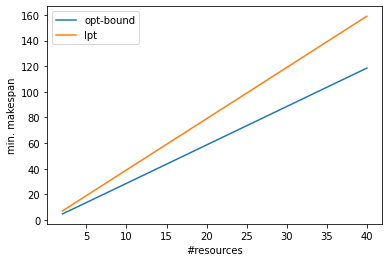

In [2]:
num_trials = 5
max_iters = 1000

resources = [2, *range(5, 45, 5)]
problem_instances = [(R, suboptimal_instance(R)) for R in resources]

def eval_lpt(R, p):
    _, m, r, = lpt(R, p)
    return m / r, m

lpt_df = pd.DataFrame(data=(eval_lpt(R, p) for R, p in problem_instances), index=resources, columns=['opt-bound', 'lpt'])
lpt_df.plot.line(xlabel='#resources', ylabel='min. makespan')

## Simulated Annealing

### Sanity check
Note that the optimal value for this instance is 9.

In [3]:
_, makespan = anneal(R=3, p=[5, 5, 4, 4, 3, 3, 3])
makespan

9.0

### SA evaluation
Comparison of the solution quality between SA and LPT on problem instances for which LPT is known to be sub-optimal.

Because SA is stochastic algorithm we take the mean value evaluated on `num_trials` per problem instance. Futhermore, each run uses `max_iters`.

Finally, SA is evaluated for each of the following *tweak* operators:
1. `vec_tweak` - for each task re-assign it to random resource with probabilyty `1/n` (`n` is no. tasks)
1. `point_tweak` - pick a task at random and assign it to random resource
1. `swap_tweak` - pick two tasks at random and swap the resources they are assigned to
each operator is then used with/witout fitness penalty `#unused resources * M` where `M` is some big-enough constant (marked with P).

In [4]:
def sa_makespan(R, p, tweak, penalize):
    _, m = anneal(R, p, tweak, max_iters, penalize=penalize)
    return m

def evaluate_sa(tweak, penalize):
    for R, p in problem_instances:
        # mean makespan
        yield sum(sa_makespan(R, p, tweak, penalize) for _ in range(num_trials)) / num_trials

In [5]:
tweak_df = pd.DataFrame({tweak.__name__: evaluate_sa(tweak, penalize=False) for tweak in [vec_tweak, point_tweak, swap_tweak]}, index=resources)
tweak_df = pd.concat([lpt_df, tweak_df], axis=1)
tweak_df

,opt-bound,lpt,vec_tweak,point_tweak,swap_tweak
2,4.666667,7.0,6.0,6.0,7.2
5,13.571429,19.0,16.6,16.8,20.0
10,28.536585,39.0,41.6,41.4,48.4
15,43.524590,59.0,67.8,67.0,72.6
20,58.518519,79.0,98.2,99.6,111.2
25,73.514851,99.0,131.2,128.0,160.2
30,88.512397,119.0,161.0,163.8,179.8
35,103.510638,139.0,212.2,194.6,227.0
40,118.509317,159.0,230.6,237.2,245.8


In [6]:
tweak_df.max()

opt-bound      118.509317
lpt            159.000000
vec_tweak      230.600000
point_tweak    237.200000
swap_tweak     245.800000
dtype: float64

<AxesSubplot:xlabel='#resources (R)', ylabel='min. makespan (mean for SA)'>

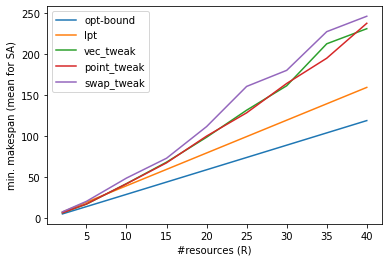

In [7]:
tweak_df.plot.line(xlabel='#resources (R)', ylabel='min. makespan (mean for SA)')

Now let's try one of the better tweak operators with a penalty to solution quality. This penalty is equal to `#unused resources * M` where `M` is some big-enough constant (e.g. `M = sum(p)`).

<AxesSubplot:xlabel='#resources (R)', ylabel='mean min. makespan (vec_tweak)'>

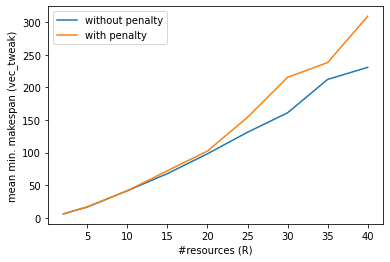

In [8]:
tweak_penalty_df = pd.DataFrame(
    {
        'without penalty': tweak_df['vec_tweak'],
        'with penalty': evaluate_sa(tweak=vec_tweak, penalize=True),
    },
    index=resources,
)
tweak_penalty_df.plot.line(xlabel='#resources (R)', ylabel='mean min. makespan (vec_tweak)')

In [9]:
tweak_penalty_df.max()

without penalty    230.6
with penalty       309.0
dtype: float64

## Evolutionary strategies
- `(num_parents,pop_size)` ES - from a population of size `pop_size` select `num_parents` fittest individuals and create new population by tweaking them
- `(num_parents+pop_size)` ES - similar to `(num_parents,pop_size)` ES but parents get automatically promoted to next generation

### Sanity check
Note that the optimal value for this instance is 9.

In [10]:
_, makespan = evo_strat(R=3, p=[5, 5, 4, 4, 3, 3, 3], tweak=vec_tweak)
makespan

9.0

In [11]:
_, makespan = evo_strat(R=3, p=[5, 5, 4, 4, 3, 3, 3], tweak=vec_tweak, elitism=True)
makespan

9.0

### ES evaluation
Comparison of the solution quality between both ES and LPT on problem instances where LPT is known to be sub-optimal.

There are two main variants of ES (described above) with two main parameters:
 * `num_parents` - specifies how many fittests individuals participate in creating new generation
 * `pop_size` - specifies how many children are created in total each generation

Because ES is stochastic algorithm we take the mean value evaluated on `num_trials` per problem instance. Futhermore, each run uses `max_iters`. Finally, all ES versions use `vec_tweak` as the mutation operator.

In [12]:
def es_makespan(R, p, num_parents, pop_size, elitism):
    _, m = evo_strat(
        R=R,
        p=p,
        num_parents=num_parents,
        pop_size=pop_size,
        elitism=elitism,
        max_iters=max_iters,
        penalize=False,
    )
    return m

def evaluate_es(num_parents, pop_size, elitism):
    for R, p in problem_instances:
        # mean makespan
        yield sum(es_makespan(R, p, num_parents, pop_size, elitism) for _ in range(num_trials)) / num_trials

In [13]:
def es_name(par, pop, elitism):
    op = '+' if elitism else ','
    return f'({par}{op}{pop}) ES'

es_df = pd.DataFrame(
    {
        es_name(num_parents, pop_size, elitism): evaluate_es(num_parents, pop_size, elitism)
        for num_parents in [5, 10]
        for pop_size in [10, 100]
        for elitism in [False, True]
    },
    index=resources,
)
es_df = pd.concat([lpt_df, es_df], axis=1)
es_df

,opt-bound,lpt,"(5,10) ES",(5+10) ES,"(5,100) ES",(5+100) ES,"(10,10) ES",(10+10) ES,"(10,100) ES",(10+100) ES
2,4.666667,7.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0
5,13.571429,19.0,16.0,16.4,15.4,15.8,16.0,16.4,15.4,15.4
10,28.536585,39.0,34.4,33.6,32.6,32.6,38.0,34.6,32.8,33.0
15,43.524590,59.0,54.8,52.8,51.0,52.2,64.2,54.8,49.4,52.6
20,58.518519,79.0,75.8,74.8,67.6,72.0,92.8,70.2,68.2,71.8
25,73.514851,99.0,98.8,95.2,85.4,89.4,118.4,95.0,86.6,88.8
30,88.512397,119.0,121.0,116.8,103.2,111.4,150.6,118.8,102.6,109.4
35,103.510638,139.0,144.6,143.0,122.6,129.2,183.8,142.2,122.2,129.8
40,118.509317,159.0,167.6,160.8,139.6,155.2,217.0,164.2,139.8,150.4


In [14]:
es_df.max()

opt-bound      118.509317
lpt            159.000000
(5,10) ES      167.600000
(5+10) ES      160.800000
(5,100) ES     139.600000
(5+100) ES     155.200000
(10,10) ES     217.000000
(10+10) ES     164.200000
(10,100) ES    139.800000
(10+100) ES    150.400000
dtype: float64

<AxesSubplot:title={'center':'Ratio to LPT for R=40'}, ylabel='quality/quality(LPT)'>

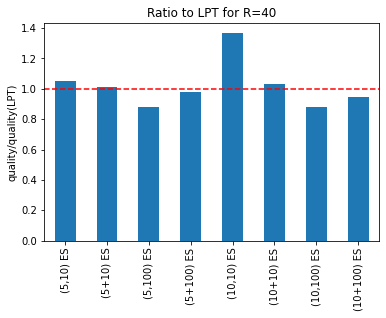

In [15]:
es_max_lpt_ratio = es_df - es_df['opt-bound']
es_max_lpt_ratio = (es_df.loc[40] / es_df.lpt.loc[40])
es_max_lpt_ratio.drop(['opt-bound', 'lpt'], inplace=True)

ax = es_max_lpt_ratio.plot.bar(ylabel='quality/quality(LPT)', title='Ratio to LPT for R=40')
ax.axhline(y=1, color='r', linestyle='--')
ax

<AxesSubplot:xlabel='#resources (R)', ylabel='min. makespan (mean for ES)'>

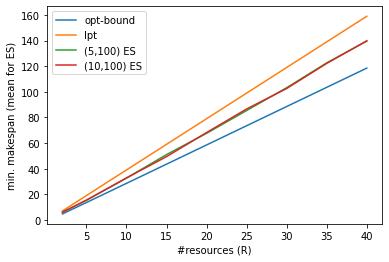

In [16]:
good_es_df = pd.concat((es_df[c] for c in es_df.columns if all(es_df[c] <= es_df.lpt) and '+' not in c), axis=1)
good_es_df.plot.line(xlabel='#resources (R)', ylabel='min. makespan (mean for ES)')

# Evolutionary algorithms

### Sanity check
Note that the optimal value for this instance is 9.

In [17]:
_, makespan = evolve(R=3, p=[5, 5, 4, 4, 3, 3, 3], mate=two_point_crossover, mutate=mutation(vec_tweak, R=3))
makespan

9.0

### EA evaluation
Comparison of the solution quality between EA and LPT on problem instances for which LPT is known to be sub-optimal.

Because EA is stochastic algorithm we take the mean value evaluated on `num_trials` per problem instance. Futhermore, each run uses `max_iters`.

Finally, EA uses `vec_tweak` as the mutation operator, `two_point_crossover` as the mating operator and we run it for 
* varying population sizes: 10, 100
* with/witout fitness penalty `#unused resources * M` where `M` is some big-enough constant (marked with P)

In [18]:
def ea_makespan(R, p, pop_size, penalize):
    _, m = evolve(
        R=R,
        p=p,
        mate=two_point_crossover,
        mutate=mutation(vec_tweak, R),
        pop_size=pop_size,
        max_iters=max_iters,
        penalize=penalize,
    )
    return m

def evaluate_evolve(pop_size, penalize):
    for R, p in problem_instances:
        # mean makespan
        yield sum(ea_makespan(R, p, pop_size, penalize) for _ in range(num_trials)) / num_trials

In [19]:
evolve_df = pd.DataFrame({f'evolve-{pop_size}': evaluate_evolve(pop_size, penalize=False) for pop_size in [10, 100]}, index=resources)
evolve_df = pd.concat([lpt_df, evolve_df], axis=1)

In [20]:
evolve_df.max()

opt-bound     118.509317
lpt           159.000000
evolve-10     166.000000
evolve-100    149.600000
dtype: float64

<AxesSubplot:xlabel='#resources (R)', ylabel='min. makespan (mean for EA)'>

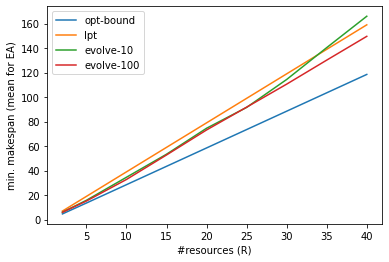

In [21]:
evolve_df.plot.line(xlabel='#resources (R)', ylabel='min. makespan (mean for EA)')

Similarly to SA, let's check if using a penalty for unused resources helps to find better schedules.

<AxesSubplot:xlabel='#resources (R)', ylabel='min. makespan (mean for EA; pop=10)'>

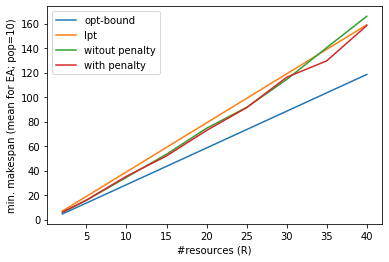

In [22]:
penalty_df = pd.DataFrame(
    {
        'witout penalty': evolve_df['evolve-10'],
        'with penalty': evaluate_evolve(pop_size=10, penalize=True),
    },
    index=resources,
)
penalty_df = pd.concat([lpt_df, penalty_df], axis=1)
penalty_df.plot.line(xlabel='#resources (R)', ylabel='min. makespan (mean for EA; pop=10)')

In [23]:
penalty_df.max()

opt-bound         118.509317
lpt               159.000000
witout penalty    166.000000
with penalty      158.400000
dtype: float64